In [1]:
import scanpy as sc
import scvi
from tqdm.notebook import tqdm
import os
import numpy as np
import pandas as pd
from scvi.model.utils import mde
import matplotlib.pyplot as plt
import pickle
import glob

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


This file determines neighborhoods based on gene expression matrix, rather than spatial coordinates (does not take spatial coordinates into account)

SCVI gives us embedding space --> clustering --> cell typing --> we can determine which cell is which

In [2]:
#input_file = '/mnt/sata2/projects/Spatial/Tumor'
input_folders = glob.glob(os.path.join('/mnt/sata3/Dhruv_Analysis_1/2025_05_22_IL-15_KO', 'batch*'))
input_folders

['/mnt/sata3/Dhruv_Analysis_1/2025_05_22_IL-15_KO/batch_1',
 '/mnt/sata3/Dhruv_Analysis_1/2025_05_22_IL-15_KO/batch_3',
 '/mnt/sata3/Dhruv_Analysis_1/2025_05_22_IL-15_KO/batch_2',
 '/mnt/sata3/Dhruv_Analysis_1/2025_05_22_IL-15_KO/batch_4']

In [3]:
adatalist=[]
for input_file in input_folders:
    adata = sc.read(os.path.join(input_file, "adatas", '04_tissue_cleared.h5ad'))
    name = os.path.basename(input_file)
    adata.obs['batch'] = name
    adatalist.append(adata)

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
adata=sc.concat(adatalist)

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata.obsm['X_spatial']

array([[ 387.97341919, 4178.38427734],
       [ 446.73092651, 4162.96044922],
       [ 442.37832642, 4166.30810547],
       ...,
       [2838.13574219, 6861.86376953],
       [2868.41943359, 6875.15429688],
       [2982.94458008, 6910.59472656]])

In [7]:
# configure and train scvi model: autoencoder for dimensionality reduction from 480 genes to 30 latent variables
adata.layers["counts"] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
vae.train()

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9/9: 100%|██████████| 9/9 [06:03<00:00, 37.79s/it, v_num=1, train_loss_step=146, train_loss_epoch=153]

`Trainer.fit` stopped: `max_epochs=9` reached.


Epoch 9/9: 100%|██████████| 9/9 [06:03<00:00, 40.41s/it, v_num=1, train_loss_step=146, train_loss_epoch=153]


In [8]:
# get latent representation of the data and compute neighbors
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")

In [9]:
adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])

Jun 02 02:54:58 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jun 02 02:54:58 PM: The following items have duplicates [ 16123  17429  23042  46446 500750 557507 629037 786154]


In [13]:
sc.tl.leiden(adata, resolution = 1.5)

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


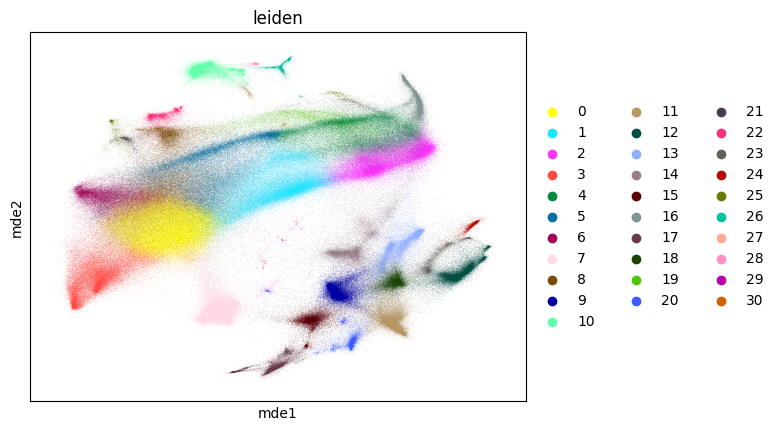

In [14]:
sc.pl.embedding(adata,basis="mde",color="leiden")

In [11]:
try:
    os.mkdir(os.path.join(os.path.dirname(input_file), "combined"))
except:
    print("booyah")


In [15]:
adata.write(os.path.join(os.path.dirname(input_file), "combined", '05_scvi.h5ad'))

: 